# Text Processing and Classification

In [1]:
import pandas as pd
import json
from ast import literal_eval
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
import base64
# pip install spacy
#python -m spacy download en_core_web_lg

In [2]:
df = pd.read_csv("articles-w-full_engagement.csv", sep = "~")
df = df.drop(columns = ["date_saved", "sharecount"])

In [7]:
df = pd.read_csv("articles-w-full_engagement.csv", sep = "~")
df = df.drop(columns = ["date_saved", "sharecount"])

alltimepeaks = pd.read_csv("csv/wiki-10alltimepeaks.csv", sep = ";")

# Turn the species in the wiki all time peaks into a list 
peaks = list(alltimepeaks['scientific_name'].unique())
# Using the list create a subset dataframe from these species and reset index
news_filtered = df.loc[df['scientific_name'].isin(peaks)].reset_index(drop = True)

# Make sure date is stored as datetime
news_filtered['date'] = pd.to_datetime(news_filtered['date'])
# More filters and grouping
news_filtered = news_filtered.loc[news_filtered.date.dt.year > 2014].reset_index(drop=True)


news = news_filtered.groupby([(news_filtered.date.dt.year), (news_filtered.date.dt.month), (news_filtered.scientific_name)])['shares'].sum()\
        .sort_values(ascending=False).rename_axis(["Year", "Month", "scientific_name"]).reset_index()

### NLTK and Geonamescache

In [4]:
import re
import string
from bs4 import BeautifulSoup
import nltk # pip install nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy 
# pip install spacy

2023-04-25 12:09:17.776114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 12:09:18.059083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-25 12:09:18.059157: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-25 12:09:18.117829: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-25 12:09:19.401902: W tensorflow/stream_executor/platform/de

In [16]:
import geonamescache
# pip install geonamescache
gc = geonamescache.GeonamesCache()

# gets nested dictionary for countries
countries = gc.get_countries()

# To avoid tensorflow warnings 
TF_CPP_MIN_LOG_LEVEL="2"
nlp = spacy.load('en_core_web_lg')

# Create a new column named 'processed_txt'
#df['processed_txt'] = None

# Apply the language model under 'nlp' to the contents of the DataFrame column 'text'
#df['processed_txt'] = df['text'].apply(nlp) 

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
#Function retrieved from https://www.dataknowsall.com/textcleaning.html

def clean_string(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['also', 'said', 'would', 'could', 'should', 'told', 'say', 'like', 'u', 
                                     'see', 'day', 'since', 'red', 'often', 'one', 'two', 'time', 'animal', 'tiger', 'lion', 'elephant',
                                    'panda', 'species', 'rhino', "—"]

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string


# Sample application of function
df['text_clean'] = df['text'].apply(lambda x: clean_string(x, stem='Lem'))

# Apply the language model under 'nlp' to the contents of the DataFrame column 'text'
#rizz_media['spacy'] = rizz_media['text_clean_spcy'].apply(nlp)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Obtained from https://stackoverflow.com/questions/59444065/differentiate-between-countries-and-cities-in-spacy-ner/59458133#59458133

def gen_dict_extract(var, key):
    if isinstance(var, dict):
        for k, v in var.items():
            if k == key:
                yield v
            if isinstance(v, (dict, list)):
                yield from gen_dict_extract(v, key)
    elif isinstance(var, list):
        for d in var:
            yield from gen_dict_extract(d, key)
            
countries = [*gen_dict_extract(countries, 'name')]   
countries = [txt.lower() for txt in countries]

In [19]:
# Define a function named 'get_ents' that takes spacy text and the spacy label
# We refer to this input using the variable name 'nlp_text'.
def get_ents(nlp_text, label):
    
    # First we make sure that the input is of correct type
    # by using the assert command to check the input type
    assert type(nlp_text) == spacy.tokens.doc.Doc
    
    # Let's set up a placeholder list for our ne's
    ents = []
    
    # We begin then begin looping over the Doc object
    for ent in nlp_text.ents:
        if (ent.label_ == label):
            if ent.text in countries: # if the word is a country name
                ents.append(ent.text) # Append the ent text to the list of ents to return
            
    # When the loop is complete, return the list of ents
    return ents

In [18]:
# Create a new column named 'processed_txt'
df['processed_txt'] = None

# Apply the language model under 'nlp' to the contents of the DataFrame column 'text'
df['processed_txt'] = df['text_clean'].apply(nlp)

In [25]:
# Apply the 'get_ents' function to the column 'processed_txt'
# Store as a separate lists all values tagged with GPE
gpe_list = []

for i in df['processed_txt']:
    x = get_ents(i, "GPE")
    gpe_list.append(x)

In [38]:
for i in df['processed_txt']:
    for ent in i.ents:
          print(ent, ent.label_)
    
          break

tempoco jakarta GPE
tempoco jakarta director biodiversity conservation ministry environment forestry ORG
east lampung LOC
tempoco nairobi ORG
tempoco phnom penh GPE
jakarta GPE
tempoco GPE
louisiana coastal ORG
yasmeen banuin PERSON
sharea grevy PERSON
korea GPE
ten CARDINAL
sodwana bay FAC
kelly dolphin PERSON
today DATE
alex kirbybbc PERSON
helen briggsbbc PERSON
many half CARDINAL
first ORDINAL
przewalski NORP
alex kirbybbc PERSON
east kallmantanpreviously PERSON
madagascarrhettt butler mongabaycommay PRODUCT
three CARDINAL
asian NORP
matthew wellsbbc PERSON
catfish legaltina butler mongabaycomjune ORG
nearly nine foot long  meter QUANTITY
compoundstina ORG
thursday DATE
madagascar lemur ORG
hungerrhett butlerjuly PERSON
u germany ORG
amazonancient ORG
releaseseptember ORG
richard blackenvironment PERSON
whythe ORG
helen briggsbbc PERSON
researchrhett butler mongabaycomjanuary PERSON
panamanian NORP
january DATE
japan GPE
richard blackenvironment PERSON
identifiedrhett butler mongab

In [89]:
# Create a daatframe from the countries list 
gpe_df = pd.DataFrame({"Countries":gpe_list})
# Concatenate with the dataframe 
df_new = pd.concat([df, gpe_df], axis = 1)
#df_new.to_pickle('csv/pickled_df.pkl')

In [94]:
df_new.drop(columns = ['text', 'date_saved', 'ner']).to_csv("csv/processed10wikipeaks.csv", sep = "~", index = False)

In [79]:
test1 = []

for x in news_filtered['txt_clean_lem']:
    items = x.split(' ')
    test1.append(items)
    
txt_words = pd.DataFrame({"txt_lems":test1})
t = pd.concat([news_filtered, txt_words], axis = 1)
t.head()  

,common_name,scientific_name,distribution,iucn_status,date_saved,text,title,link,image,date,ner,url,shares,reactions,comments,txt_clean_lem,txt_lems
0,Square-lipped Rhinoceros,Ceratotherium simum,"Angola, Botswana, Central African Republic, Ch...",Near Threatened,2020-06-18,Three female white rhinoceros escaped a safari...,Israeli rhino named Rihanna escapes local safari,https://news.google.com/articles/CBMiOmh0dHBzO...,https://www.ynetnews.com/PicServer3/2013/01/01...,2015-01-01,[{'sent': 'Three female white rhinoceros escap...,"https://www.ynetnews.com/articles/0,7340,L-461...",0.0,0.0,0.0,three female white rhinoceros escaped safari c...,"[three, female, white, rhinoceros, escaped, sa..."
1,Amur Tiger,Panthera tigris,"Afghanistan, Bangladesh, Bhutan, Cambodia, Chi...",EN,2020-06-18,"For the first time, conservationists have spot...",Photo First: Rare Tiger Family Portrait,https://news.google.com/articles/CBMiQWh0dHBzO...,https://cdn.mos.cms.futurecdn.net/GiUhM5vndrft...,2015-03-10,"[{'sent': ""For the first time, conservationist...",https://www.livescience.com/50093-amur-tiger-f...,0.0,0.0,0.0,first conservationist spotted amur dad leading...,"[first, conservationist, spotted, amur, dad, l..."
2,Indian Lion,Panthera leo,"Afghanistan, Algeria, Angola, Benin, Botswana,...",VU,2020-06-18,New Delhi: In his Independence Day speech last...,Does Narendra Modi like lions more than tigers?,https://news.google.com/articles/CBMiY2h0dHBzO...,https://images.livemint.com/rf/Image-621x414/L...,2015-04-24,[{'sent': 'New Delhi: In his Independence Day ...,https://www.livemint.com/Politics/ZpXwvuIML2vM...,0.0,0.0,0.0,new delhi independence speech last year prime ...,"[new, delhi, independence, speech, last, year,..."
3,White Rhinoceros,Ceratotherium simum,"Angola, Botswana, Central African Republic, Ch...",Near Threatened,2020-06-18,With rhino numbers collapsed due to poaching f...,At home with the world's last male northern wh...,https://news.google.com/articles/CBMidGh0dHBzO...,https://i.guim.co.uk/img/media/5ee08ab5a77c5e9...,2015-04-27,[{'sent': 'With rhino numbers collapsed due to...,https://www.theguardian.com/environment/2015/a...,389.0,2865.0,440.0,number collapsed due poaching horn lot ride pa...,"[number, collapsed, due, poaching, horn, lot, ..."
4,Asiatic Lion,Panthera leo,"Afghanistan, Algeria, Angola, Benin, Botswana,...",VU,2020-06-18,Census finds 27% increase in number of endange...,India's Asiatic lion population rising,https://news.google.com/articles/CBMiWWh0dHBzO...,https://i.guim.co.uk/img/static/sys-images/Gua...,2015-05-11,[{'sent': 'Census finds 27% increase in number...,https://www.theguardian.com/environment/2015/m...,248.0,1754.0,88.0,census find increase number endangered lion f...,"[census, find, , increase, number, endangered,..."


In [98]:
t.to_excel("csv/processedtxt_10wiki.xlsx", engine='xlsxwriter')

In [84]:
t.to_csv("csv/articles_10peaks_wiki.csv", sep = "/", index = False)

In [81]:
# Saving top 500 words to create topics out of 
t.explode('txt_lems')['txt_lems'].value_counts().nlargest(1000)
#title_wrds.to_csv("txt_lems.csv")

            5449
zoo          762
year         491
wildlife     485
lion         470
            ... 
tag           23
mount         23
gave          23
savanna       23
join          23
Name: txt_lems, Length: 1000, dtype: int64

In [ ]:
txt

In [13]:
# Explode the lists in the Countries column so each species has one row dedicated per country
s = df_new.explode('Countries').groupby(['scientific_name'])['Countries'].value_counts()

In [35]:
# create csv
s.to_csv("csv/Countries_byspecies_count.csv", sep = ';')

In [50]:
# Explode the lists in the Countries column so each species has one row dedicated per country
#s = df_new.explode('Countries').groupby(['scientific_name'])['Countries'].value_counts()
# create csv
#s.to_csv("Countries_inarticles_count.csv", sep = ';')

# read in newly created dataframe 
country_count = pd.read_csv("csv/Countries_byspecies_count.csv", sep = ';')
# read in relevant datafile
x = pd.read_csv("csv/speciesinfo.csv", sep = ";")

country_count = country_count.rename(columns = {'Countries.1' : 'mentions_country'})

country_count = country_count.merge(x, on = 'scientific_name', how = 'inner')

# Save to csv for geocoding in other notebook
country_count.to_csv("speciesinfo_gpetags.csv", sep = ';', index = False)

In [23]:
def list_to_graph(name):

    # Set up the placeholder list
    final_list = []

    # Loop over each list in the list of lists
    for nlist in name:
    
        # Extend the final list with the current list
        final_list.extend(nlist)
    
    # Convert the list into a pandas Series, count unique nouns
    # using the value_counts() method, get the 10 most frequent
    # items [:10] and plot the result into a bar chart using the
    # plot() method and its attribute 'kind'.
    return pd.Series(final_list).value_counts()[:15].plot(kind='bar')

### Sentiment analysis

In [2]:
# Read in the processed dataframe
alltext = pd.read_csv("articles_no_engagement.csv", sep = ";")
len(alltext)

13066

In [4]:
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):

	# Create a SentimentIntensityAnalyzer object.
	sid_obj = SentimentIntensityAnalyzer()

	# polarity_scores method of SentimentIntensityAnalyzer
	# object gives a sentiment dictionary.
	# which contains pos, neg, neu, and compound scores.
	sentiment_dict = sid_obj.polarity_scores(sentence)

	# decide sentiment as positive, negative and neutral
	if sentiment_dict['compound'] >= 0.05 :
		return("Positive")

	elif sentiment_dict['compound'] <= - 0.05 :
		return("Negative")

	else :
		return("Neutral")



scores = []
# Driver code
if __name__ == "__main__" :
    
    for text in alltext['text']:

        #print("Article text:", text)
	# function calling
        score = sentiment_scores(text)
        scores.append(score)
        
len(scores)

13066

In [5]:
alltext = pd.concat([alltext, pd.DataFrame({'sentiment': scores})], axis = 1)

In [6]:
alltext['sentiment'].value_counts()

Positive    9162
Negative    3726
Neutral      178
Name: sentiment, dtype: int64

In [8]:
alltext.to_csv("alltext-no-engagement-sentimet.csv", sep = ";", index = False)

#### Reading in stored data for better investigation

In [2]:
# Read in the processed dataframe
sentext = pd.read_csv("alltext-no-engagement-sentimet.csv", sep = ";")
len(sentext)

13066

In [5]:
df = sentext.copy()
df

,common_name,scientific_name,distribution,iucn_status,date_saved,Kingdom,Class,Order,Family,Genus,...,Listing,NativeDistributionFullNames,Extinct_Distribution,text,title,link,image,date,ner,sentiment
0,White-winged Wood Duck,Asarcornis scutulata,"Bangladesh, Cambodia, India, Indonesia, Lao Pe...",EN,2020-06-18,Animalia,Aves,Anseriformes,Anatidae,Asarcornis,...,I,"Bangladesh,Cambodia,India,Indonesia,Lao People...",NaN,"TEMPO.CO, East Lampung - President Joko Widodo...",Jokowi Names Sumatran Rhino `Delilah`,https://news.google.com/articles/CBMiQ2h0dHBzO...,https://statik.tempo.co/data/2015/02/09/id_369...,1970-01-01,"[{'sent': 'TEMPO.CO, East Lampung - President ...",Positive
1,White-winged Wood Duck,Asarcornis scutulata,"Bangladesh, Cambodia, India, Indonesia, Lao Pe...",EN,2020-06-18,Animalia,Aves,Anseriformes,Anatidae,Asarcornis,...,I,"Bangladesh,Cambodia,India,Indonesia,Lao People...",NaN,"TEMPO.CO, Jakarta - Holding a huge appeal for ...",Lampung Holds Huge Appeal for International To...,https://news.google.com/articles/CBMiU2h0dHA6L...,https://statik.tempo.co/data/2015/02/01/id_366...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - Holding a huge ...",Positive
2,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,Animalia,Mammalia,Primates,Hylobatidae,Hylobates,...,I,Indonesia,NaN,"TEMPO.CO, Phnom Penh - Wildlife researchers in...",Cambodia Conservationists Find Rare Cache of C...,https://news.google.com/articles/CBMiXGh0dHBzO...,https://statik.tempo.co/data/2014/11/25/id_346...,1970-01-01,"[{'sent': ""TEMPO.CO, Phnom Penh - Wildlife res...",Positive
3,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,Animalia,Mammalia,Primates,Hylobatidae,Hylobates,...,I,Indonesia,NaN,"TEMPO.CO, Nairobi - The world`s last male nort...",World`s Last Male Northern White Rhino Dies,https://news.google.com/articles/CBMiSmh0dHBzO...,https://statik.tempo.co/data/2017/08/23/id_635...,1970-01-01,"[{'sent': 'TEMPO.CO, Nairobi - The world`s las...",Negative
4,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,Animalia,Mammalia,Primates,Hylobatidae,Hylobates,...,I,Indonesia,NaN,"TEMPO.CO, Jakarta - A Javan Leopard (Panthera ...",Javan Leopard Spotted in West Java Conservatio...,https://news.google.com/articles/CBMiVGh0dHBzO...,https://statik.tempo.co/data/2016/03/31/id_494...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - A Javan Leopard...",Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13061,Panther,Panthera pardus,"Afghanistan, Algeria, Angola, Armenia, Azerbai...",VU,2020-06-18,Animalia,Mammalia,Carnivora,Felidae,Panthera,...,I,"Afghanistan,Algeria,Angola,Armenia,Azerbaijan,...","Hong Kong, SAR,Libya,Singapore,Syrian Arab Rep...",Lonzo Ball is never one to shy away from an op...,"Lonzo Ball jokingly compares JJ Redick, Jrue H...",https://news.google.com/articles/CBMihAFodHRwc...,https://usatlonzowire.files.wordpress.com/2020...,2020-05-31,[{'sent': 'Lonzo Ball is never one to shy away...,Positive
13062,Irrawaddy Dolphin,Orcaella brevirostris,"Australia, Bangladesh, Brunei Darussalam, Camb...",EN,2020-06-18,Animalia,Mammalia,Cetacea,Delphinidae,Orcaella,...,I,"Australia,Bangladesh,Brunei Darussalam,Cambodi...",NaN,"In a unique initiative, researchers from the I...",IIT researchers help Chilika Lake in Odisha to...,https://news.google.com/articles/CBMiiwFodHRwc...,https://www.deccanherald.com/sites/dh/files/ar...,2020-05-31,"[{'sent': 'In a unique initiative, researchers...",Positive
13063,Lion-tailed Macaque,Macaca silenus,India,Endangered,2020-06-18,Animalia,Mammalia,Primates,Cercopithecidae,Macaca,...,I,India,NaN,"During the nation-wide lockdown, most governme...",Flood of approvals by wildlife board sets the ...,https://news.google.com/articles/CBMiemh0dHBzO...,https://www.deccanherald.com/sites/dh/files/ar...,2020-05-31,[{'sent': 'But this nation-wide inactivity has...,Positive
13064,Japanese Giant Salamander,Andrias japonicus,"Japan, Russian Federation",Near Threatened

In [15]:
# Assuming your dataframe is named 'df' and sentiment column is named 'sentiment'
positive_rows = df[df['sentiment'] == 'Positive'].sample(n=60, random_state=42)
negative_rows = df[df['sentiment'] == 'Negative'].sample(n=40, random_state=42)

selected_rows = pd.concat([positive_rows, negative_rows])
selected_rows = selected_rows.sample(frac=1, random_state=42)
selected_rows = selected_rows.reset_index(drop=True)
# Randomly shuffle the selected rows


selected_rows.to_csv("csv/manual_sentiment_classification.csv", sep = ";", index = False)

In [16]:
# To store excel make sure to install openpyxl
selected_rows.to_excel("manual_sentiment_classification.xlsx")

There are 11290 words in the combination of all cells in column title.


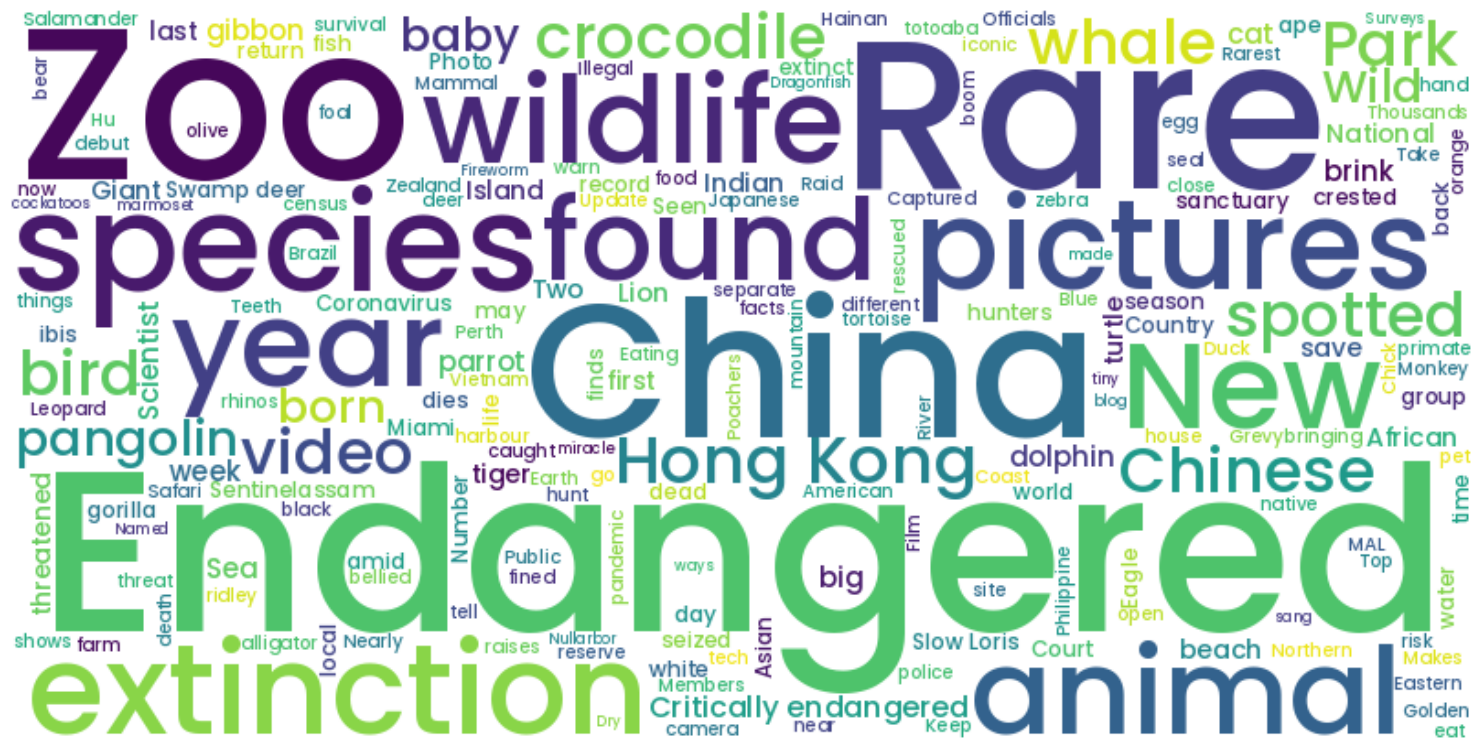

In [10]:
from wordcloud import WordCloud #pip install wordcloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

# Articles with Positive sentiment classification
pos = sentext.loc[sentext['sentiment'] == "Positive"]
# Articles with Negative sentiment classification
neg = sentext.loc[sentext['sentiment'] == "Negative"]

# Change to choose a certain IUCN status to display
mid = sentext.loc[sentext['sentiment'] == "Neutral"]

# Change to title or text
text = " ".join(i for i in mid.title)
print ("There are {} words in the combination of all cells in column title.".format(len(text))) 

stopwords = set(STOPWORDS)
stopwords.update(["s"])
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white", 
                      font_path='fonts/Poppins-Medium.ttf',
                      width=800, 
                      height=400, 
                      #mask=transformed_mask, 
                      #contour_width=1, 
                      #contour_color='green'
                      ).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

wordcloud.to_file("figures/neutral-text.png")

### Keep in case of loss of processed text CSV

In [5]:
# read in the dataset 
df = pd.read_json('animal_news_database.json', lines = True)
# Read in the datasets defining our subset data

charismatic = pd.read_csv("csv/charismatic_16.csv", sep = ";")
charismatic = charismatic.rename(columns = {'Scientifc Name' : 'scientific_name'})

# Drop Twitter handles as they are not species names
df = df[df.scientific_name.str.contains('@') == False]
df.reset_index(drop = True, inplace = True)

# Add new column for storing the values article amount found under each species type 
df['article_amt'] = df['articles'].str.len()
# What is the total amount of articles before any processing
print("Before any processing, the amount of articles in the datset:", df['article_amt'].sum())

# Read in the CITES data to join with the main dataframe
cites1 = pd.read_csv("csv/cites1.csv", delimiter = ';')

# Keep only most relevant columns
cites1 = cites1[['Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Scientific Name', 'Listing', 'NativeDistributionFullNames', 'Extinct_Distribution']]

cites1 = cites1.rename(columns = {'Scientific Name' : 'scientific_name'})

# Do the same for the entire dataframe
df = df.merge(cites1, on = 'scientific_name', how = 'inner')


#df.head()
df = df.drop(['_id'], axis=1)

Before any processing, the amount of articles in the datset: 13565


In [6]:
# Any changes after merging with CITES data
print("The amount of articles in the datset:", df['article_amt'].sum())
print("The number of species in the dataset:", df['scientific_name'].nunique())

The amount of articles in the datset: 13855
The number of species in the dataset: 584


In [3]:
#### Unneccessary as defining charisma hasn't been really realized as an option


df['Charisma'] = 0

# Loop through the species and create a binary classification for species that are charismatic or not
for x in df['scientific_name']:
    if x in list(charismatic['scientific_name']):
        df.loc[df['scientific_name'] == x, 'Charisma'] = 1

In [10]:
# Explode the articles column
s = df['articles'].map(dict.values).explode()
# NaN values need to be droppped
s = s.dropna()
# Drop the column articles and join the exploded values to the dataframe
df_full = df.drop(columns=['articles']).join(pd.DataFrame([*s], s.index))

In [34]:
uniquelinks = pd.DataFrame(df_full['link'].unique()).dropna().reset_index(drop=True)
uniquelinks.to_csv("csv/uniquelinks.csv", sep = ";", index = False)

In [9]:
# Processing for articles       
# keep only unique article instances
df_media = df_full.drop_duplicates(subset=['text'])
# Transform date column into DateTime
df_media["date"] = df_media["date"].apply(pd.to_datetime)
# Sort by oldest to newest
df_media = df_media.sort_values(by="date")
# Drop article amt column, unneccessary 
#df_media = df_media.drop(columns=['article_amt'])
# reset index
df_media.reset_index(drop = True, inplace = True)
# Remove any rows with blank data for the text column
df_media = df_media[df_media['text'].notna()]

/tmp/ipykernel_80/3856464177.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_media["date"] = df_media["date"].apply(pd.to_datetime)


### Topics

In [40]:
threats = pd.read_csv("csv/codebook_keythreats.csv", sep = ";")

In [50]:
#threats["keys"] = threats['keywords'].apply(lambda x: x.split(", "))

## Lemmatize the words 
lem = WordNetLemmatizer()

# loop through the list words in the keys column
for lst in threats['keys']:
    for wrds in lst:
        text_stemmed = lem.lemmatize(wrds)

In [21]:
# pip install nltk
import nltk
import re
import string
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')
#Function retrieved from https://www.dataknowsall.com/textcleaning.html

def clean_string(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['also', 'said', 'would', 'could', 'should', 'told', 'say', 'like', 'u', 
                                     'see', 'day', 'since', 'red', 'often', 'one', 'two', 'time']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
# Apply the function to the any column with text and save as new column
sentext['txt_clean_lem'] = sentext['text'].apply(lambda x: clean_string(x, stem='Lem'))
threats['words_clean_lem'] = threats['keywords'].apply(lambda x: clean_string(x, stem='Lem'))

test1 = []
# Turn into lists
for x in sentext['txt_clean_lem']:
    items = x.split(' ')
    test1.append(items)

# Append as a new column, save into new df
key_words = pd.DataFrame({"txt_lems":test1})
sentext = pd.concat([sentext, key_words], axis = 1)

In [39]:
#threats = threats.drop(columns = "keywords")

for i, words in threats['words_clean_lem'].items():
    print(words)

deforestation urbanization land use change fragmentation agriculture mining dam construction road building logging wildfire soil degradation connectivity ecological corridor destruction habitat loss biodiversity loss land conservation protected area
global warming greenhouse gas carbon emission sea level rise ocean acidification extreme weather event drought flood heatwaves melting glacier shifting climate zone methane nitrous oxide carbon dioxide fossil fuel  sea level rise climate change conference climate action climate science climate change
air pollution particulate matter ozone smog acid rain traffic emission exhaust water pollution agricultural runoff microplastics water contamination nutrient pollution algal bloom eutrophication soil contamination plastic waste plastic straw fishing net singleuse plastic plastic bottle plastic bag debris chemical runoff industrial emission oil spill agricultural runoff ewaste noise pollution sound pollution traffic noise aircraft noise industri

In [27]:
# Saving top 500-1000 words to create topics out of 
text_simplified = t.explode('title_lems')['title_lems'].value_counts().nlargest(1000)
text_simplified.to_csv("csv/text_lems.csv")

In [33]:
docsbyCategory = {}

for i, words in sentext['txt_clean_lem'].items():
    cats = set()
    word = words.split()
    for category, keywords in threats.items():
        if any(keyword in word for keyword in keywords.items()):
            cats.add(category)
    docsbyCategory[i] = list(cats)
    
print(docsbyCategory)
        
  

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 35: [], 36: [], 37: [], 38: [], 39: [], 40: [], 41: [], 42: [], 43: [], 44: [], 45: [], 46: [], 47: [], 48: [], 49: [], 50: [], 51: [], 52: [], 53: [], 54: [], 55: [], 56: [], 57: [], 58: [], 59: [], 60: [], 61: [], 62: [], 63: [], 64: [], 65: [], 66: [], 67: [], 68: [], 69: [], 70: [], 71: [], 72: [], 73: [], 74: [], 75: [], 76: [], 77: [], 78: [], 79: [], 80: [], 81: [], 82: [], 83: [], 84: [], 85: [], 86: [], 87: [], 88: [], 89: [], 90: [], 91: [], 92: [], 93: [], 94: [], 95: [], 96: [], 97: [], 98: [], 99: [], 100: [], 101: [], 102: [], 103: [], 104: [], 105: [], 106: [], 107: [], 108: [], 109: [], 110: [], 111: [], 112: [], 113: [], 114: [], 115: [], 116: [], 117: [], 118: [], 119: [], 120: [], 121: [], 122: [], 12

In [64]:
rz = pd.concat([rz, pd.DataFrame({"topics":docsbyCategory})], axis = 1)

In [115]:
rz.to_csv('csv/rz_media.csv', sep = ';', index = False)

In [85]:
test = rz.explode('topics')

In [88]:
test.columns

Index(['common_name', 'scientific_name', 'distribution', 'iucn_status',
       'date_saved', 'Kingdom', 'Class_x', 'Order', 'Family', 'Genus',
       'Species', 'Listing', 'NativeDistributionFullNames',
       'Extinct_Distribution', 'Common name', 'General ID name', 'Count',
       'Class_y', 'Ecosystem', 'Appendix', 'Appendix exceptions, if any',
       'text', 'title', 'link', 'image', 'date', 'ner', 'processed_txt',
       'text_clean_spcy', 'GPE', 'LOC', 'ORG', 'title_clean_lem', 'topics'],
      dtype='object')

In [91]:
#test['COUNTER'] =1 
test.groupby(['topics','scientific_name', 'title'])['COUNTER'].sum()

topics               scientific_name   title                                                                                              
CAPTIVE POPULATIONS  Acinonyx jubatus  Best Friends With A Purpose: Cheetah Has A Therapy Dog At The Turtle Back Zoo                          1
                                       Bringing the Zoo to You: April 2020 Edition                                                            1
                                       Colchester Zoo's cheetah Sia successfully gives birth to five cubs                                     1
                                       Columbus Zoo announces first baby cheetah cubs born via IVF                                            1
                                       Elusive Siberian tigers captured in spectacular photos                                                 1
                                                                                                                                             

In [19]:
# How many uncategorized articles in dataset with current categorization system
print(len(rz.loc[rz['topics'].isin(['[]'])]))


len(rz)

NameError: name 'rz' is not defined

In [112]:
#test['COUNTER'] =1       #initially, set that counter to 1.
group_data = test.groupby(['topics','scientific_name', 'title'])['COUNTER'].sum()

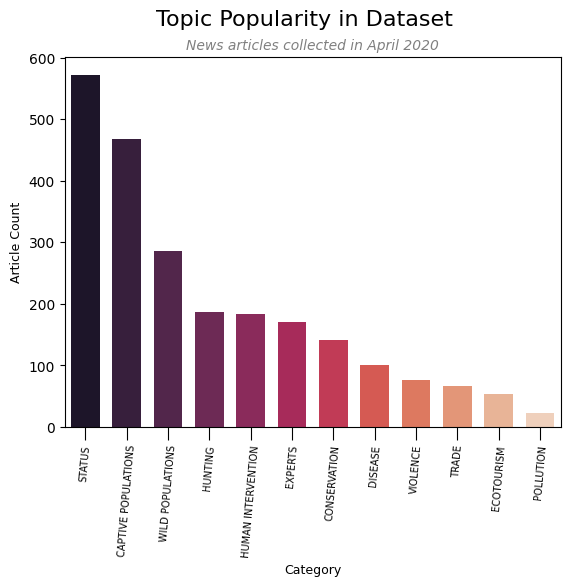

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt


ax = sns.barplot(
    x = 'topics',
    y = 'article_count',
    data = ser_df, 
    width = 0.7, palette = 'rocket', dodge = False
)
ax.set_xlabel('Category', fontsize=9)
ax.set_ylabel('Article Count', fontsize=9)

# Add suptitle above the title
plt.suptitle("Topic Popularity in Dataset\n", fontsize=16)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('News articles collected in April 2020', fontsize = 10, color="grey", style='italic')


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 7, left = True)
#ax.legend()#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0
#plt.savefig('figures/topic_popularity.png', bbox_inches = 'tight')

In [101]:
ser = rz.explode('topics')['topics'].value_counts()

In [103]:
ser_df = pd.DataFrame(ser).reset_index()
ser_df.columns = ['topics', 'article_count']
ser_df

,topics,article_count
0,STATUS,572
1,CAPTIVE POPULATIONS,468
2,WILD POPULATIONS,286
3,HUNTING,187
4,HUMAN INTERVENTION,184
5,EXPERTS,170
6,CONSERVATION,141
7,DISEASE,100
8,VIOLENCE,77
9,TRADE,66
